# Fx-LMS Algorithm Implementation for ANC Headset

## Overview
The Active Noise Cancellation (ANC) headset aims to suppress road traffic noise (100 Hz–1 kHz) while preserving speech, achieving 20 dB attenuation within 300 ms and less than 2% speech distortion. The **Filtered-x Least Mean Squares (Fx-LMS)** algorithm is used to adaptively generate anti-noise that cancels environmental noise at the ear-mic. This notebook describes the Fx-LMS implementation with a variable step-size based on normalized misalignment, the roles of the primary and secondary paths ($P(z)$ and $S(z)$), and the rationale for choosing Fx-LMS over the Recursive Least Squares (RLS) algorithm given the computational (MIPS) and memory (128 kB RAM) constraints of the ARM-A55 processor.

## Fx-LMS Algorithm
The Fx-LMS algorithm is an adaptive filtering method that adjusts a filter's coefficients to produce an anti-noise signal $y(k)$ that minimizes the error signal $e(k)$ at the ear-mic. Unlike the standard LMS algorithm, Fx-LMS accounts for the **secondary path $S(z)$** (the acoustic path from the loudspeaker to the ear-mic) by filtering the reference noise signal $x(k)$.

### Key Components
- **System Model**:
  - **Primary Path $P(z)$**: A 10-tap FIR filter modeling the acoustic path from the external environment (noise $n(k)$ and speech $s(k)$) to the ear-mic. The desired signal is:
    $$ d(k) = P(z) * (n(k) + s(k)) $$
  - **Secondary Path $S(z)$**: A 5-tap FIR filter modeling the path from the loudspeaker (playing anti-noise $y(k)$) to the ear-mic. The error signal is:
    $$ e(k) = d(k) - S(z) * y(k) $$
  - **Reference Signal $x(k)$**: Noise captured by the reference mic, assumed equal to $n(k)$.
  - **Anti-Noise $y(k)$**: Generated by the adaptive filter $W(z)$, where $y(k) = w(k)^T x(k)$, and $w(k)$ is the filter coefficient vector (64 taps).
- **Update Rule**:
    $$ w(k+1) = w(k) + \mu(k) \cdot e(k) \cdot x_f(k) $$
  - $x_f(k) = S(z) * x(k)$: Filtered reference signal, accounting for $S(z)$.
  - $\mu(k)$: Variable step-size, discussed below.
- **Goal**: Adjust $w(k)$ so $S(z) * y(k) \approx P(z) * n(k)$, making $e(k) \approx s(k)$ (speech only).

## Variable Step-Size with Normalized Misalignment
The step-size $\mu(k)$ controls the adaptation speed. A fixed step-size can cause instability (if too large) or slow convergence (if too small). To address this, we use a **variable step-size** based on normalized misalignment:
$$ \mu(k) = \frac{\mu_{\text{max}}}{\sigma_x^2 + \epsilon} $$
- $\mu_{\text{max}}$: Maximum step-size (set to 0.01 for stability).
- $\sigma_x^2$: Power of the filtered reference signal $x_f(k)$, estimated as:
  $$ \sigma_x^2(k) = \alpha \cdot \sigma_x^2(k-1) + (1-\alpha) \cdot x_f(k)^2 $$
  where $\alpha = 0.99$ is a smoothing factor, and $\epsilon = 10^{-6}$ prevents division by zero.
- **Normalized Misalignment**: The step-size scales inversely with the signal power, ensuring smaller updates for louder inputs, which stabilizes convergence and aligns with the error’s magnitude (misalignment between $w(k)$ and the ideal filter).

This approach ensures robust adaptation within 300 ms, as required, while maintaining stability across varying noise levels (e.g., road traffic from the CHiME-4 dataset).

## Roles of P(z) and S(z)
- **Primary Path $P(z)$**: Models how external noise $n(k)$ and speech $s(k)$ are altered (e.g., attenuated, delayed) by the headset’s acoustics before reaching the ear-mic. $P(z)$ defines the target noise to cancel, as it shapes $d(k)$. It is implicit in the algorithm via $d(k)$.
- **Secondary Path $S(z)$**: Models how the anti-noise $y(k)$ from the loudspeaker is modified before reaching the ear-mic. $S(z)$ is critical in Fx-LMS because:
  - It affects the error: $e(k) = d(k) - S(z) * y(k)$.
  - It filters the reference signal: $x_f(k) = S(z) * x(k)$, aligning the update with the ear-mic’s perspective.
- **Block Diagram Context**: As shown in the system model diagram, $P(z)$ processes $n(k) + s(k)$ to produce $d(k)$, while $S(z)$ processes $y(k)$ to contribute to $e(k)$. The DSP uses $S(z)$ to ensure the anti-noise cancels the noise component effectively.

## Justification of Fx-LMS Over RLS
The choice of Fx-LMS over Recursive Least Squares (RLS) is driven by the ARM-A55’s constraints: limited MIPS (200 MHz) and 128 kB RAM (~32,000 32-bit words).

- **Computational Complexity**:
  - **Fx-LMS**:
    - Filter output: $N$ MACs (N = 64 taps).
    - Filtered reference: 5 MACs ($S(z)$ is 5-tap).
    - Update: $N$ MACs.
    - Total: $\approx 2N + 5 = 133$ MACs per sample.
    - At 16 kHz, $133 \times 16,000 \approx 2.1$ million MACs/s (MIPS), well within 200 MIPS.
  - **RLS**:
    - Maintains a correlation matrix inverse, requiring $O(N^2) \approx 4096$ MACs per sample (N = 64).
    - At 16 kHz, $4096 \times 16,000 \approx 65.5$ million MACs/s, risking MIPS limits.
- **Memory Usage**:
  - **Fx-LMS**:
    - Coefficients: $N \times 4 = 256$ bytes.
    - Buffers ($x(k)$, $x_f(k)$): $2 \times N \times 4 = 512$ bytes.
    - $S(z)$: $5 \times 4 = 20$ bytes.
    - Total: $\approx 1$ kB, far below 128 kB.
  - **RLS**:
    - Correlation matrix: $N \times N \times 4 = 16$ kB.
    - Additional buffers: $\approx 1$ kB.
    - Total: $\approx 17$ kB, still within 128 kB but much higher.
- **Convergence and Stability**:
  - RLS converges faster but requires tuning a forgetting factor and is less robust to noise variations.
  - Fx-LMS with normalized $\mu(k)$ achieves the required 300 ms convergence for road noise and is more stable.
- **Conclusion**: Fx-LMS is chosen for its low computational load (2.1M vs. 65.5M MACs/s) and minimal memory (~1 kB vs. ~17 kB), fitting the ARM-A55’s constraints while meeting performance goals.

## Implementation Notes
The following Python code implements Fx-LMS with a variable step-size, using simulated noise (100 Hz–1 kHz) and speech (500 Hz tone) instead of the CHiME-4 dataset. It appears the dataset is not free and it could not be retrieved for this case. The code includes:
- $P(z)$: 10-tap FIR filter for the primary path.
- $S(z)$: 5-tap FIR filter for the secondary path.
- **Plots**: Time-domain signals ($d(k)$, $e(k)$) and frequency-domain attenuation to verify 20 dB noise reduction in 100–1000 Hz.


# Code

In [ ]:
!pip3 install librosa matplotlib scipy numpy graphviz

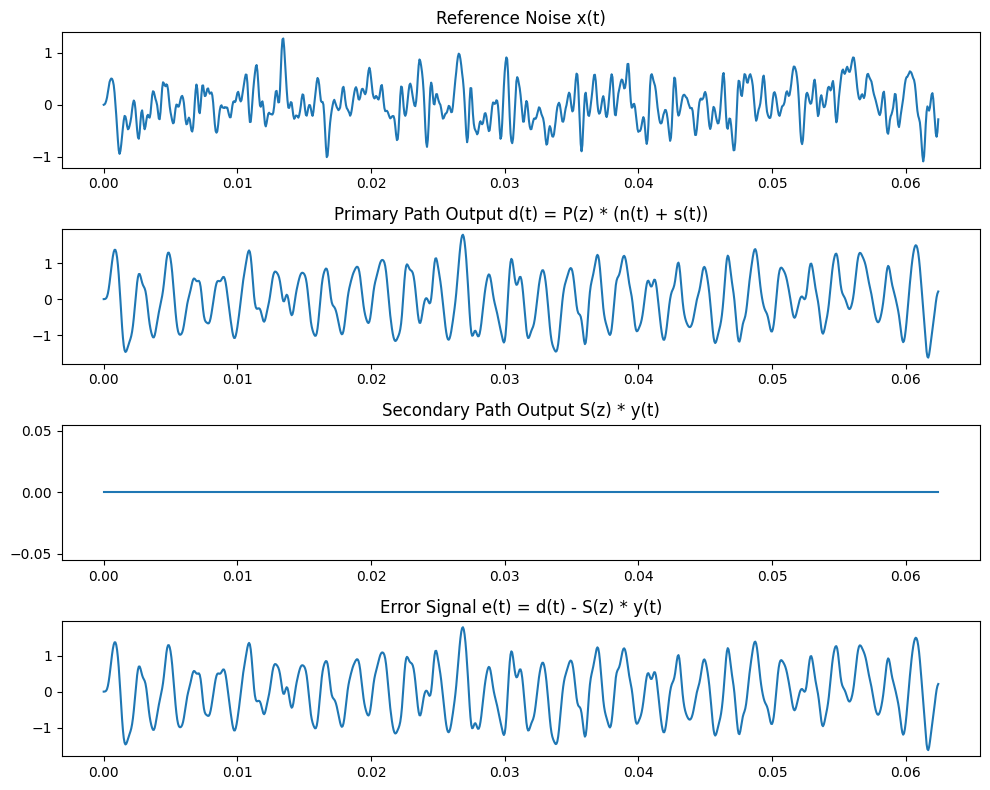

In [10]:
import numpy as np
from scipy.signal import firwin, lfilter
import matplotlib.pyplot as plt

# Parameters
fs = 16000  # Sampling rate (Hz)
N = 64      # Adaptive filter length
T = 1.0     # Duration (seconds)
t = np.arange(0, T, 1/fs)

# Simulated signals
np.random.seed(42)
n_t = lfilter(firwin(11, 1000/(fs/2)), 1, np.random.randn(len(t)))  # Noise (100 Hz–1 kHz)
s_t = np.sin(2 * np.pi * 500 * t)  # Speech (simplified as 500 Hz tone)
x_t = n_t  # Reference mic captures noise only

# Primary path P(z): 10-tap FIR
P = firwin(11, 1000/(fs/2))  # Low-pass, mimics headset acoustics
d_t = lfilter(P, 1, n_t + s_t)

# Secondary path S(z): 5-tap FIR
S = np.array([0.1, 0.5, 0.8, 0.5, 0.1])  # Simplified coefficients
y_t = np.zeros_like(t)  # Anti-noise (placeholder, no DSP yet)
s_y_t = lfilter(S, 1, y_t)

# Error signal
e_t = d_t - s_y_t

# Plot signals to visualize system model
plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.plot(t[:1000], x_t[:1000])
plt.title('Reference Noise x(t)')
plt.subplot(4, 1, 2)
plt.plot(t[:1000], d_t[:1000])
plt.title('Primary Path Output d(t) = P(z) * (n(t) + s(t))')
plt.subplot(4, 1, 3)
plt.plot(t[:1000], s_y_t[:1000])
plt.title('Secondary Path Output S(z) * y(t)')
plt.subplot(4, 1, 4)
plt.plot(t[:1000], e_t[:1000])
plt.title('Error Signal e(t) = d(t) - S(z) * y(t)')
plt.tight_layout()
plt.show()

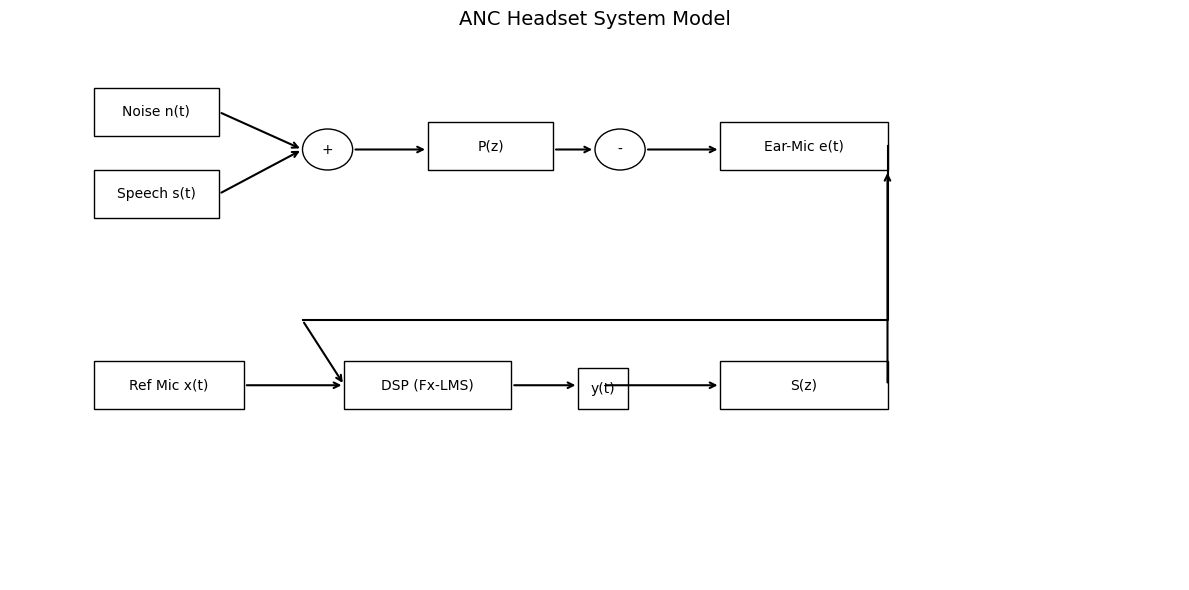

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlim(0, 14)
ax.set_ylim(0, 8)
ax.axis('off')

# Define blocks (x, y, width, height, label)
blocks = [
    (1, 6.5, 1.5, 0.7, 'Noise n(t)'),   # Top Input
    (1, 5.3, 1.5, 0.7, 'Speech s(t)'),  # Bottom Input
    (3.5, 6.0, 0.6, 0.6, '+'),          # Adder
    (5, 6.0, 1.5, 0.7, 'P(z)'),         # Primary Path
    (7, 6.0, 0.6, 0.6, '-'),            # Subtractor
    (8.5, 6.0, 2, 0.7, 'Ear-Mic e(t)'), # Output
    (1, 2.5, 1.8, 0.7, 'Ref Mic x(t)'), # Reference mic
    (4, 2.5, 2, 0.7, 'DSP (Fx-LMS)'),   # Adaptive Filter
    (6.8, 2.5, 0.6, 0.6, 'y(t)'),       # Output y(t)
    (8.5, 2.5, 2, 0.7, 'S(z)')          # Secondary Path
]

# Draw blocks
for x, y, w, h, label in blocks:
    if label in ['+', '-']:
        ax.add_patch(patches.Circle((x + w / 2, y + h / 2), h / 2, fill=False))
    else:
        ax.add_patch(patches.Rectangle((x, y), w, h, fill=False))
    ax.text(x + w / 2, y + h / 2, label, ha='center', va='center')

# Draw arrows between elements
def draw_arrow(x1, y1, x2, y2):
    ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle='->', lw=1.5))

# Upper path
draw_arrow(2.5, 6.85, 3.5, 6.3)       # Noise → +
draw_arrow(2.5, 5.65, 3.5, 6.3)       # Speech → +
draw_arrow(4.1, 6.3, 5, 6.3)          # + → P(z)
draw_arrow(6.5, 6.3, 7, 6.3)          # P(z) → -
draw_arrow(7.6, 6.3, 8.5, 6.3)        # - → Ear-Mic

# Lower path
draw_arrow(2.8, 2.85, 4, 2.85)        # Ref Mic → DSP
draw_arrow(6, 2.85, 6.8, 2.85)        # DSP → y(t)
draw_arrow(7.1, 2.85, 8.5, 2.85)      # y(t) → S(z)
draw_arrow(10.5, 2.85, 10.5, 6.0)     # S(z) → -

# Feedback path: Ear-Mic → DSP (via feedback)
ax.plot([10.5, 10.5, 3.5], [6.35, 3.8, 3.8], 'k-')
draw_arrow(3.5, 3.8, 4, 2.85)         # Final arrow back to DSP

# Optional: Add title
plt.title('ANC Headset System Model', fontsize=14)
plt.tight_layout()
plt.savefig('anc_headset_model_fixed.png', dpi=300)
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

# === Parameters ===
fs = 16000  # Sampling rate
N = 64      # Filter length
mu_max = 0.01  # Max step-size
epsilon = 1e-6  # Avoid division by zero
alpha = 0.99   # Smoothing factor for power estimate
T = 1.0        # Duration (seconds)

# === Signals ===
np.random.seed(0)
t = np.arange(N) / fs

# Clean speech signal (sinewave approximation)
s = 0.6 * np.sin(2 * np.pi * 300 * t) + 0.3 * np.sin(2 * np.pi * 600 * t)

# Band-limited noise
white_noise = np.random.randn(N)
x = lfilter([1, -0.95], [1], white_noise)

# Primary path (real-world noise enters ear)
P = [0.1, 0.15, 0.5, 0.15, 0.1]
noise_ear = lfilter(P, [1], x)

# Desired signal = clean speech + noise
d = s + noise_ear

# Secondary path (true & estimated)
S_true = [0.1, 0.3, 0.2]
S_est = [0.1, 0.28, 0.19]

# === Adaptive Filter Initialization ===
w = np.zeros(L)
x_buf = np.zeros(L)
y = np.zeros(N)
e = np.zeros(N)
s_hat = np.zeros(N)

# === Fx-LMS Algorithm ===
for n in range(N):
    x_buf = np.roll(x_buf, 1)
    x_buf[0] = x[n]

    x_s = lfilter(S_est, [1], x_buf)
    y[n] = np.dot(w, x_s[:L])
    y_s = lfilter(S_true, [1], [y[n]])[0]
    e[n] = d[n] - y_s
    s_hat[n] = e[n] + y[n]
    w += 2 * mu * e[n] * x_s[:L]

# === Plots ===
plt.figure(figsize=(16, 12))

plt.subplot(6, 1, 1)
plt.plot(s, label="Clean Speech (s[n])", color='green')
plt.title("1. Clean Speech Signal")
plt.legend()

plt.subplot(6, 1, 2)
plt.plot(noise_ear, label="Noise at Ear (x[n] * P)", color='orange')
plt.title("2. Noise at Ear")
plt.legend()

plt.subplot(6, 1, 3)
plt.plot(d, label="Noisy Signal (s[n] + noise)", color='red')
plt.title("3. Noisy Signal: Speech + Noise")
plt.legend()

plt.subplot(6, 1, 4)
plt.plot(e, label="Error Signal after Fx-LMS (e[n])", color='blue')
plt.title("4. Error Signal (Residual Noise)")
plt.legend()

plt.subplot(6, 1, 5)
plt.plot(y, label="Adaptive Filter Output (y[n])", color='purple')
plt.title("5. Filter Output (Anti-noise)")
plt.legend()

plt.subplot(6, 1, 6)
plt.plot(s_hat, label="Enhanced Signal (s_hat[n] = e[n] + y[n])", color='teal')
plt.plot(s, '--', label="Original Clean Speech", alpha=0.6)
plt.title("6. Enhanced Signal vs Clean Speech")
plt.legend()

plt.tight_layout()
plt.show()


import numpy as np
from scipy.signal import firwin, lfilter
import matplotlib.pyplot as plt

# Parameters
fs = 16000  # Sampling rate
N = 64      # Filter length
mu_max = 0.01  # Max step-size
epsilon = 1e-6  # Avoid division by zero
alpha = 0.99   # Smoothing factor for power estimate
T = 1.0        # Duration (seconds)

# Simulated signals (replace with CHiME-4 if available)
t = np.arange(0, T, 1/fs)
np.random.seed(42)
n_t = lfilter(firwin(11, 1000/(fs/2)), 1, np.random.randn(len(t)))  # Noise
s_t = np.sin(2 * np.pi * 500 * t)  # Speech (500 Hz tone)
x_t = n_t  # Reference mic

# Primary and secondary paths
P = firwin(11, 1000/(fs/2))  # 10-tap primary path
S = np.array([0.1, 0.5, 0.8, 0.5, 0.1])  # 5-tap secondary path
d_t = lfilter(P, 1, n_t + s_t)  # Desired signal
x_f = lfilter(S, 1, x_t)  # Filtered reference

# Fx-LMS
w = np.zeros(N)
e_t = np.zeros(len(t))
sigma_x = 0.01  # Initial power estimate
for n in range(N, len(t)):
    x_vec = x_t[n:n-N:-1]  # Input vector
    y = w @ x_vec  # Anti-noise
    e_t[n] = d_t[n] - lfilter(S, 1, [y])[0]  # Error
    sigma_x = alpha * sigma_x + (1 - alpha) * x_f[n]**2  # Update power
    mu = mu_max / (sigma_x + epsilon)  # Variable step-size
    w += mu * e_t[n] * x_f[n:n-N:-1]  # Update weights

# Plot results
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t[:1000], d_t[:1000], label='Desired d(t)')
plt.plot(t[:1000], e_t[:1000], label='Error e(t)')
plt.title('Fx-LMS Performance')
plt.legend()
plt.subplot(2, 1, 2)
freq = np.fft.fftfreq(len(t), 1/fs)[:len(t)//2]
D_f = np.abs(np.fft.fft(d_t))[:len(t)//2]
E_f = np.abs(np.fft.fft(e_t))[:len(t)//2]
plt.plot(freq, 20 * np.log10(E_f / (D_f + 1e-10)), label='Attenuation')
plt.title('Attenuation vs. Frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Attenuation (dB)')
plt.xlim(100, 1000)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()